<a href="https://colab.research.google.com/github/yh0010/NYU_Summer_Tandon_Scholar_Intro2ML/blob/main/Elaina_9_hw_unsupervised_state_of_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment: the state of machine learning and data science

Summer 2021

**Attribution**: this notebook is modeled after similar work by [Paige Bailey](https://twitter.com/DynamicWebPaige/status/1406250082194841601).

* **Name**: Elaina Huang
* **Net ID**: yh4310

Now that we're wrapping up our survey of machine learning, you may be wondering what to do next. What are machine learning engineers and data scientists currently most excited about? What software frameworks and tools do they want to try out? Where are they going to learn new things?

Of course, if you ask different people these questions, you'll get many different answers. Or, if you ask 20,000 people, you'll get 20,000 different answers…

In this notebook, we'll work with the 2020 Kaggle Machine Learning & Data Science Survey.  Kaggle is an online community for machine learning and data science enthusiasts to find and share data sets and models. In their annual survey, they ask their users to answer questions about how they use machine learning and what they are looking forward to doing next.

The survey results can potentially give us some insight into what's next in machine learning.

Of course, you could just look at the most common answers to each question and stop there! But, that won't give us the full picture. We expect that there may be "cohorts" among Kaggle users who have different interests or different background: for example, there might be some respondents who use machine learning mainly for business analytics, some who use it as a hobby, some who are students, etc. Among different "cohorts", the most popular tools and techniques are likely to be different. 

Depending on which "cohort" you identify with most closely, the overall most common answers may not be very useful to you - you may be more interested in what other members of "your cohort" are doing and anticipating.

In this notebook, we will use unsupervised learning methods to try and find that underlying "cohort" structure in the data, and use it to gain insight into the state of machine learning and data science.

## Load and install libraries

We'll start by loading some familiar libraries:

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, fixed
import ipywidgets as widgets
from mpl_toolkits import mplot3d
from matplotlib import cm, colors
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import re #regular expression

We'll also install a new library that's not pre-installed in Colab. This UMAP library will implement a dimensionality reduction method that we'll use later in the notebook:

In [ ]:
!pip install umap-learn

     |████████████████████████████████| 80 kB 3.2 MB/s 
     |████████████████████████████████| 1.1 MB 25.2 MB/s 
  Created wheel for umap-learn: filename=umap_learn-0.5.1-py3-none-any.whl size=76564 sha256=24f809b4752be3c894958dd9448afc1e666f180fca34c0695ec843a5f82a5aeb
  Stored in directory: /root/.cache/pip/wheels/01/e7/bb/347dc0e510803d7116a13d592b10cc68262da56a8eec4dd72f
  Created wheel for pynndescent: filename=pynndescent-0.5.4-py3-none-any.whl size=52373 sha256=f5ac93f34f08afdabdf834050d2886cf4ce3de7f046a569ce8a92e12c764d1c4
  Stored in directory: /root/.cache/pip/wheels/d0/5b/62/3401692ddad12324249c774c4b15ccb046946021e2b581c043
Successfully built umap-learn pynndescent


In [ ]:
from umap import UMAP

## Read in and process data


First, download the data and the survey documentation:

* [Kaggle 2020 survey data](https://drive.google.com/file/d/1fGNDBlpziYMAVHSXQJpcLd_AhrsFkVf3/view?usp=sharing)
* [Kaggle 2020 survey questions and answer options](https://drive.google.com/file/d/1yVsd9r1E6s6qh6n5UYlLxs8mKSl5VMzC/view?usp=sharing)
* [Kaggle 2020 methodology]()

Review the survey questions and the answer options for each question.

Upload the survey data (CSV file) to your Colab workspace:

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving kaggle_survey_2020_responses.csv to kaggle_survey_2020_responses.csv
User uploaded file "kaggle_survey_2020_responses.csv" with length 25431748 bytes


The CSV file has two header rows - one with a question number, and one with the question text. We'll read the question text into one data frame, and the responses into another data frame.


In [ ]:
questions = pd.read_csv('kaggle_survey_2020_responses.csv', header=[0], nrows=1)
questions

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,Duration (in seconds),What is your age (# years)?,What is your gender? - Selected Choice,In which country do you currently reside?,What is the highest level of formal education ...,Select the title most similar to your current ...,For how many years have you been writing code ...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming languages do you use on a reg...,What programming language would you recommend ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following integrated development ...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,Which of the following hosted notebook product...,...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which of the following business intelligence t...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which categories of automated machine learning...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool...,Which specific automated machine learning tool.

In [ ]:
responses = pd.read_csv('kaggle_survey_2020_responses.csv', header=[0], skiprows=[1])
responses

,Time from Start to Finish (seconds),Q1,Q2,Q3,Q4,Q5,Q6,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q8,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1838,35-39,Man,Colombia,Doctoral degree,Student,5-10 years,Python,R,SQL,C,NaN,NaN,Javascript,NaN,NaN,NaN,MATLAB,NaN,Other,Python,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",NaN,NaN,Visual Studio Code (VSCode),NaN,Spyder,NaN,NaN,NaN,NaN,NaN,NaN,Kaggle Notebooks,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,SAP Analytics Cloud,NaN,NaN,"Automated data augmentation (e.g. imgaug, albu...",NaN,NaN,NaN,Automated hyperparameter tuning (e.g. hyperopt...,Automation of full ML pipelines (e.g. Google C...,NaN,NaN,Google Cloud AutoML,NaN,Databricks AutoML,NaN,NaN,Auto-Keras,Auto-Sklearn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,TensorBoard,NaN,NaN,NaN,NaN,NaN,NaN
1,289287,30-34,Man,United States of America,Master’s degree,Data Engineer,5-10 years,Python,R,SQL,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,Visual Studio,NaN,PyCharm,NaN,NaN,Sublime Text,NaN,NaN,NaN,NaN,NaN,Colab Notebooks,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,860,35-39,Man,Argentina,Bachelor’s degree,Software Engineer,10-20 years,NaN,NaN,NaN,NaN,NaN,Java,Javascript,NaN,NaN,Bash,NaN,NaN,NaN,R,NaN,NaN,NaN,Visual Studio Code (VSCode),NaN,NaN,Notepad++,Sublime Text,Vim / Emacs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN
3,507,30-34,Man,United States of America,Master’s degree,Data Scientist,5-10 years,Python,NaN,SQL,NaN,NaN,NaN,NaN,NaN,NaN,Bash,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,PyCharm,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,78,30-34,Man,Japan,Master’s degree,Software Engineer,3-5 years,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Python,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20031,126,18-21,Man,Turkey,Some college/university study without earning ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20032,566,55-59,Woman,United Kingdom of Great Britain and Northern I...,Master’s degree,Current

We're going to focus specifically on answers to machine learning-related questions, and exclude demographic information. Also, to make it easier, we'll just use the columns that are already essentially one-hot encoded.

So, we will drop the following columns from the data:

In [ ]:
drop_cols = ['Time from Start to Finish (seconds)', 
             'Q1', 'Q2', 'Q3', 'Q4', 'Q5', 'Q6', 'Q8', 'Q11', 
             'Q13', 'Q15', 'Q20', 'Q21', 'Q22', 'Q24', 'Q25', 
             'Q30', 'Q32', 'Q38']
responses_sub = responses.drop(columns = drop_cols)
questions_sub = questions.drop(columns = drop_cols)

In [ ]:
responses_sub.describe()

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
count,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Python,R,SQL,C,C++,Java,Javascript,Julia,Swift,Bash,MATLAB,None,Other,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,Visual Studio,Visual Studio Code (VSCode),PyCharm,Spyder,Notepad++,Sublime Text,Vim / Emacs,MATLAB,None,Other,Kaggle Notebooks,Colab Notebooks,Azure Notebooks,Paperspace / Gradient,Binder / JupyterHub,Code Ocean,IBM Watson Studio,Amazon Sagemaker Studio,Amazon EMR Notebooks,Google Cloud AI Platform Notebooks,Google Cloud Datalab Notebooks,Databricks Collaborative Notebooks,None,Other,GPUs,...,Einstein Analytics,Qlik,Domo,TIBCO Spotfire,Alteryx,Sisense,SAP Analytics Cloud,None,Other,"Automated data augmentation (e.g. imgaug, albu...",Automated feature engineering/selection (e.g. ...,"Automated model selection (e.g. auto-sklearn, ...",Automated model architecture searches (e.g. da...,Automated hyperparameter tuning (e.g. hyperopt...,Automation of full ML pipelines (e.g. Google C...,None,Other,Google Cloud AutoML,H20 Driverless AI,Databricks AutoML,DataRobot AutoML,Tpot,Auto-Keras,Auto-Sklearn,Auto_ml,Xcessiv,MLbox,None,Other,Neptune.ai,Weights & Biases,Comet.ml,Sacred + Omniboard,TensorBoard,Guild.ai,Polyaxon,Trains,Domino Model Monitor,None,Other
freq,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251


In [ ]:
responses_sub.columns

Index(['Q7_Part_1', 'Q7_Part_2', 'Q7_Part_3', 'Q7_Part_4', 'Q7_Part_5',
       'Q7_Part_6', 'Q7_Part_7', 'Q7_Part_8', 'Q7_Part_9', 'Q7_Part_10',
       ...
       'Q35_B_Part_2', 'Q35_B_Part_3', 'Q35_B_Part_4', 'Q35_B_Part_5',
       'Q35_B_Part_6', 'Q35_B_Part_7', 'Q35_B_Part_8', 'Q35_B_Part_9',
       'Q35_B_Part_10', 'Q35_B_OTHER'],
      dtype='object', length=336)

Now, each column has only one possible value (or NaN). 

We can encode those values as 1s:

In [ ]:
responses_oh = responses_sub.notnull().astype('int')
responses_oh

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
0,1,1,1,1,0,0,1,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,0,0,0,1,1,0,0,1,0,1,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20031,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20032,1,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
20033,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
20034,1,0,1,1,0,1,1,0,0,0,0,0,0,1,1,0,1,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1,1,1,1,1,1,0,0,1,1,1,1,1,1,1,1,1,1,0,0,1,1,0,0,1,0,0,1,0,0,0


How do we interpret this data? 

To take an example: if the response value in row 0 is 1 for `Q7_Part_1`, this means that respondent 0 selected the first option for question 7. Looking at the survey questions and answers, we can see that this means they selected "Python" as a programming language they use on a regular basis.

## Exploratory data analysis


### To do 1: explore the data and look for high-level insight

Later in this notebook, we'll use dimensionality reduction and clustering to try and gain some deeper insight into this data. First, though, see what you can find out from the high-dimensional data. 

Use exploratory data analysis to review the data and describe your high-level insights. According to the data, what are machine learning and data science enthusiasts using right now? What are they hoping to gain more experience with soon?

Show your exploratory data analysis (code + output and visualizations) and also summarize your findings in  a text cell.

(You can use either `responses_oh` or `responses_sub` for this step.)

In [ ]:
# pd.set_option('max_rows', 99999)
pd.set_option('max_colwidth', 400)
# pd.describe_option('max_colwidth')
pd.set_option('display.max_colwidth',1000)

In [ ]:
pd.options.display.max_rows = 4000

In [ ]:
# get a copy of responses_sub.describe()
plotdata = responses_sub.describe()
plotdata

,Q7_Part_1,Q7_Part_2,Q7_Part_3,Q7_Part_4,Q7_Part_5,Q7_Part_6,Q7_Part_7,Q7_Part_8,Q7_Part_9,Q7_Part_10,Q7_Part_11,Q7_Part_12,Q7_OTHER,Q9_Part_1,Q9_Part_2,Q9_Part_3,Q9_Part_4,Q9_Part_5,Q9_Part_6,Q9_Part_7,Q9_Part_8,Q9_Part_9,Q9_Part_10,Q9_Part_11,Q9_OTHER,Q10_Part_1,Q10_Part_2,Q10_Part_3,Q10_Part_4,Q10_Part_5,Q10_Part_6,Q10_Part_7,Q10_Part_8,Q10_Part_9,Q10_Part_10,Q10_Part_11,Q10_Part_12,Q10_Part_13,Q10_OTHER,Q12_Part_1,...,Q31_B_Part_7,Q31_B_Part_8,Q31_B_Part_9,Q31_B_Part_10,Q31_B_Part_11,Q31_B_Part_12,Q31_B_Part_13,Q31_B_Part_14,Q31_B_OTHER,Q33_B_Part_1,Q33_B_Part_2,Q33_B_Part_3,Q33_B_Part_4,Q33_B_Part_5,Q33_B_Part_6,Q33_B_Part_7,Q33_B_OTHER,Q34_B_Part_1,Q34_B_Part_2,Q34_B_Part_3,Q34_B_Part_4,Q34_B_Part_5,Q34_B_Part_6,Q34_B_Part_7,Q34_B_Part_8,Q34_B_Part_9,Q34_B_Part_10,Q34_B_Part_11,Q34_B_OTHER,Q35_B_Part_1,Q35_B_Part_2,Q35_B_Part_3,Q35_B_Part_4,Q35_B_Part_5,Q35_B_Part_6,Q35_B_Part_7,Q35_B_Part_8,Q35_B_Part_9,Q35_B_Part_10,Q35_B_OTHER
count,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251
unique,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
top,Python,R,SQL,C,C++,Java,Javascript,Julia,Swift,Bash,MATLAB,None,Other,"Jupyter (JupyterLab, Jupyter Notebooks, etc)",RStudio,Visual Studio,Visual Studio Code (VSCode),PyCharm,Spyder,Notepad++,Sublime Text,Vim / Emacs,MATLAB,None,Other,Kaggle Notebooks,Colab Notebooks,Azure Notebooks,Paperspace / Gradient,Binder / JupyterHub,Code Ocean,IBM Watson Studio,Amazon Sagemaker Studio,Amazon EMR Notebooks,Google Cloud AI Platform Notebooks,Google Cloud Datalab Notebooks,Databricks Collaborative Notebooks,None,Other,GPUs,...,Einstein Analytics,Qlik,Domo,TIBCO Spotfire,Alteryx,Sisense,SAP Analytics Cloud,None,Other,"Automated data augmentation (e.g. imgaug, albumentations)","Automated feature engineering/selection (e.g. tpot, boruta_py)","Automated model selection (e.g. auto-sklearn, xcessiv)","Automated model architecture searches (e.g. darts, enas)","Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)","Automation of full ML pipelines (e.g. Google Cloud AutoML, H20 Driverless AI)",None,Other,Google Cloud AutoML,H20 Driverless AI,Databricks AutoML,DataRobot AutoML,Tpot,Auto-Keras,Auto-Sklearn,Auto_ml,Xcessiv,MLbox,None,Other,Neptune.ai,Weights & Biases,Comet.ml,Sacred + Omniboard,TensorBoard,Guild.ai,Polyaxon,Trains,Domino Model Monitor,None,Other
freq,15530,4277,7535,3315,3827,3367,2995,262,198,1776,2217,206,1945,11211,3826,2445,5873,5099,3290,3132,2452,1502,1604,386,1162,5992,6329,857,180,2072,105,846,497,245,1218,1231,394,5282,485,8310,...,556,577,181,181,343,203,1006,2115,180,2428,2540,3274,1510,2397,3161,2108,188,2479,859,801,833,446,2384,2752,1348,315,707,804,193,935,1177,494,430,3199,557,480,846,519,3082,251


In [ ]:
names = []
count = []
quest = []
separate_names = []
Q_num = 7

#purpose:
#generate a names list contain all the selection choices
#generate a count list contain all the voting number
#generate a separate names list contain all the questions names
#generate a question list contain all the question names but redundent
while True:
  col_names = []
  col_count = []
  col_separate = []
  for i in plotdata.columns:
    if i.startswith('Q{Q}'.format(Q=str(Q_num))):
    # if re.match("Q[0-9]*[0-9]_[A-Z]+", i):
      #print(i)
      col_separate.append(i)
      col_names.append(plotdata[i].loc['top'])
      col_count.append(plotdata[i].loc['count'])
      if i.startswith('Q{Q}'.format(Q=str(Q_num))) not in quest:
        quest.append('Q{Q}'.format(Q=str(Q_num)))
  names.append(col_names)
  #print(names)
  count.append(col_count)
  separate_names.append(col_separate)
  Q_num += 1
  if Q_num == 40:
    break
  
quest = pd.DataFrame(quest)[0].unique() #unique values for Question names

In [ ]:
cter = 0
for i in separate_names:
  for j in i:
    cter += 1
print(cter 
      )

336


In [ ]:
# remove all the NaN values from the lists
names = [x for x in names if x]
count = [x for x in count if x]
separate_names = [x for x in separate_names if x]

In [ ]:
len(names)
len(count)
len(quest)

21

In [ ]:
# A combined graph with both the part-A and part-B, represent a general usage/dislike/unaware level
fig = plt.figure(figsize=(100,180))
for n in range(len(count)):
  plt.subplot(7, 3, n+1)
  sns.barplot(x=names[n], y=count[n])
  plt.xticks(rotation=35)
  plt.title(quest[n]) 

Data Exploratory Analysis:

Q7. Python was the most popular **language** among voted users.

Q9. Jupyter was the most popular **IDE**.

Q10. Colab, Kaggle notebook and None scored very closely to each other in the most popular **notebook products**.

Q12. GPUs and None in the most popular **hardware**.

Q14. Popular **data visualization libraries**: Matplotlib and Seaborn

Q16. Popular **machine learning frameworks**: Scikit-learn, Tensorflow and Keras

Q17. Popular **ML algorithms**: Linear/Logistics regressio, decision tree/random forest and convolutional neural networks

Q18. Popular **computer vision** method: Image classification and other general purpose networks (VGG, Inception, ResNet,
ResNeXt, NASNet, EfficientNet, etc)

Q19. Popular **NLP** methods: Word embeddings/vectors (GLoVe, fastText, word2vec) Encoder-decoder models (seq2seq, Transformer language models (GPT-3, BERT, XLnet, etc)

Q23. Important **activities of your work**: Analyze and understand data to influence product or business decisions

Q26. Popular **cloud computing platforms**: Amazon Web Services(AWS), Google Cloud Platform(GCP), Microsoft Azure

Q27. Popular **cloud computing products**: Google cloud compute engine, Amazon EC2, AWS lamba, Azure functions, google cloud functions

Q28. Popular **ML products**: None and Google Cloud AI Platform / Google Cloud ML Engine

Q29. Popular **big data products**: MySQL, MongoDB, PostgreSQL and Microsoft SQL Server

Q31. Popular **business intelligence tools**: None, Tableau and Microsoft Power BI

Q33. Popular **autoML learning tools**: None and Automation of full ML pipelines (e.g. Google AutoML, H20 Driverless AI)

Q34. Popular **autoML learning tools**: Auto-Skilearn, auto-keras, google cloud autoML

Q35. Popular **tools to manage ML experiments**: None and Tensorboard.


**Conclusion:** Apparently, python is the leading language when conducting ML experiments. Because of that, it's reasonable to use Jupyter as the leading notebook because it's known to run python. I think the above top selections summaries can tell us a lot how the survey users behave, or what do they like, or what do they do with the tools. But one thing I want to point out is that since there are a very high number of "None" in many of the questions, I think that could potentially explain a part of the user might not be aware of certain tools/products exist to help with their ML experiments. It's possible that they might not like it but it's more likely that they are not aware of this. So I would argue that the users might be interested once they are aware of the products.


In [ ]:
# plot part-A and part-B separately
fig = plt.figure(figsize=(100,180))
for n in range(len(count)):
  plt.subplot(7, 3, n+1)
  sns.barplot(x=separate_names[n], y=count[n])
  plt.xticks(rotation=35)
  plt.title(quest[n]) 

**Conclusion:** The above graph shows how users are interested in different products, compare to users who used the product and how the actual usage level is at. It's easy to assume how the product might be preferable to someone but when it comes down to actual paying to use, people will rate the product differently. But I would say this is a good perspective to look at, there a lot of opportunities to sell the product to new users, as opposed to users who have had experience and preference on certain products.

## Dimensionality reduction


Our ultimate goal is to gain deeper insight by clustering the respondents into "cohorts", and then looking at the state of machine learning and data science as described by each cohort separately.

Because of the dimensionality of the data (hundreds of columns), it will not work very well with K-means clustering. K-means clustering also suffers from the curse of dimensionality: high dimensional data is often very sparse in the overall feature space, so that "closest" cluster mean to a particular sample may not really be much closer than the other cluster means.

Also, since K-means clustering involves distance computations, it is expensive to apply to high-dimensional data.

Finally, we want to be able to visually explore the data and the clusters, and it is very difficult to do this in hundreds of dimensions!

To address this, we'll reduce the dimension of the data to 3D. This will help with clustering, and will also make it easier to visualize the data.

### PCA

The "classic" dimensionality reduction method is PCA. Let's try to apply PCA to this data.

#### To do 2: Apply PCA

In the following cell, use the `sklearn` implementation of PCA. Create a PCA instance in a variable called `pca_reducer`, with `n_components = 3`. Then, fit it using the `responses_oh` data. Finally, use the `transform` method to project the `responses_oh` data into the 3D feature space learned by PCA. Save the result in a variable called `pca_responses`.

In [ ]:
# TODO 2

pca_reducer = PCA(n_components = 3) 
pca_responses = pca_reducer.fit_transform(responses_oh)

Verify that the `pca_responses` dataset has reduced dimensionality:

In [ ]:
responses_oh.shape #original

(20036, 336)

In [ ]:
pca_responses.shape #reduced

(20036, 3)

Let's visualize this result in 3D to see if it will make clustering easier:

In [ ]:
def plot_3D(elev=20, azim=20, pca_responses=pca_responses):

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(pca_responses[:,0], pca_responses[:,1], pca_responses[:,2], s=0.2);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         pca_responses=fixed(pca_responses));

interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…

Use the elevation and azimuth sliders to view the data from different perspectives.

### UMAP

A more recent approach called UMAP is known to often produce better results for dimensionality reduction for visualization or clustering. 

Here are some useful resources for learning about UMAP:

* [Understanding UMAP](https://pair-code.github.io/understanding-umap/)
* [How UMAP works](https://umap-learn.readthedocs.io/en/latest/how_umap_works.html)



Let's try it! We can use `UMAP` in exactly the same way that we used `PCA` - specify the number of components as 3, fit the model using the `responses_oh` data, and then use the fitted model to transform the data.

In [ ]:
umap_reducer = UMAP(n_components=3).fit(responses_oh)

/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)


In [ ]:
umap_responses = umap_reducer.transform(responses_oh)

Verify that the `umap_responses` dataset has reduced dimensionality:

In [ ]:
umap_responses.shape

(20036, 3)

And let's plot this version of the data, too:

In [ ]:
def plot_3D(elev=20, azim=20, umap_responses=umap_responses):

    fig = plt.figure(figsize=(10,10))
    ax = plt.axes(projection='3d')

    ax.scatter3D(umap_responses[:,0], umap_responses[:,1], umap_responses[:,2], s=0.2);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         umap_responses=fixed(umap_responses));

interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…

Use the elevation and azimuth sliders to view the data from different perspectives.

Which transformation of the data seems more useful for clustering?

**Conclusion:** I feel like the PCA is more symmetric and might be easier to cluster but easier might not necessarily mean is the optimal method. The UMAP is known to create more realistic transformation the graph shows how the data is structured both locally and globally and this is missing from the PCA transformation. I think it depends on the needs to use either PCA or UMAP.

## Clustering

Next, let's use a clustering algorithm to try and define distinct "cohorts" among the respondents.


#### To do 3: apply a clustering algorithm

Use a clustering algorithm from `sklearn` to find cohorts in the data. The following design choices are up to you:

* You can apply the clustering to `pca_responses` or to `umap_responses` - whichever you think is most useful for clustering.
* You can use `KMeans` or [any other clustering method](https://scikit-learn.org/stable/modules/clustering.html) implemented in `sklearn`. 
* You can decide how to initialize the cluster centers. Read the function documentation to learn about the initialization options available in the method you have chosen.
* You can choose how many clusters to find, but you must have at least 3 clusters. Save the number of clusters in a variable called `n_clusters`.

Save the cluster labels learned by your model in a variable called `c_responses`, and save the list of cluster centers in `c_centers`.

In [ ]:
# TODO 3

#UMAP clustering
n_clusters = 6
kmeans = KMeans(n_clusters=n_clusters)
clusters = kmeans.fit_predict(umap_responses)
c_responses = kmeans.labels_
c_centers = kmeans.cluster_centers_

In [ ]:
#PCA clustering
n_clusters = 6
kmeans_pca = KMeans(n_clusters=n_clusters)
clusters_pca = kmeans_pca.fit_predict(pca_responses)
c_responses_pca = kmeans_pca.labels_
c_centers_pca = kmeans_pca.cluster_centers_

In [ ]:
len(c_responses_pca)

20036

Let's visualize the results.

If you used the PCA-transformed data, use this function to visualize the results:

In [ ]:
def plot_3D(elev=20, azim=20, pca_responses=pca_responses, n_clusters=n_clusters,
            c_responses=c_responses_pca, c_centers=c_centers_pca):

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')

    cmap = plt.cm.Dark2
    norm = colors.BoundaryNorm(np.arange(0, n_clusters+1, 1), cmap.N)

    p = ax.scatter3D(pca_responses[:,0], pca_responses[:,1], pca_responses[:,2], 
                 c=c_responses, s=0.2, alpha=0.4, cmap=cmap, norm=norm);
    fig.colorbar(p)
    # note: you can adjust the value of s here to change the size of the cluster centers
    p = ax.scatter3D(c_centers[:,0], c_centers[:,1], c_centers[:,2], edgecolor='black',
                 c=range(n_clusters), s=150, cmap=cmap, norm=norm);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         pca_responses=fixed(pca_responses),  n_clusters=fixed(n_clusters),
         c_responses=fixed(c_responses_pca), c_centers=fixed(c_centers_pca));

interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…

If you used the UMAP-transformed data, use this function to visualize the results:

In [ ]:
def plot_3D(elev=20, azim=20, umap_responses=umap_responses, n_clusters=n_clusters,
            c_responses=c_responses, c_centers=c_centers):

    fig = plt.figure(figsize=(15,10))
    ax = plt.axes(projection='3d')

    cmap = plt.cm.Dark2
    norm = colors.BoundaryNorm(np.arange(0, n_clusters+1, 1), cmap.N)

    p = ax.scatter3D(umap_responses[:,0], umap_responses[:,1], umap_responses[:,2], 
                 c=c_responses, s=0.2, alpha=0.4, cmap=cmap, norm=norm);
    fig.colorbar(p)
    # note: you can adjust the value of s here to change the size of the cluster centers
    p = ax.scatter3D(c_centers[:,0], c_centers[:,1], c_centers[:,2], edgecolor='black',
                 c=range(n_clusters), s=150, cmap=cmap, norm=norm);

    ax.view_init(elev=elev, azim=azim)


interact(plot_3D, elev=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         azim=widgets.FloatSlider(min=-90,max=90,step=1, value=20),
         umap_responses=fixed(umap_responses),  n_clusters=fixed(n_clusters),
         c_responses=fixed(c_responses), c_centers=fixed(c_centers));

interactive(children=(FloatSlider(value=20.0, description='elev', max=90.0, min=-90.0, step=1.0), FloatSlider(…

Are you satisfied with your clusters? Do the cluster centers look like a good representation of the samples in the cluster?

**Yes, I think so**

Adjust your clustering (you can change the intialization, the number of clusters, or the clustering algorithm) until you are satisfied with the results.

### To do 4: Apply inverse transform to the cluster centers

Next, we'll look at the cluster centers in the original high-dimensional feature space. 

Use the `inverse_transform` method of your reducer (either the `pca_reducer` or the `umap_reducer`, depending on which type of transformed data you used for clustering). Apply this to the `c_centers` variable to get the cluster centers in the original high-dimensional feature space. Save the result in `c_centers_highd`.

In [ ]:
# TODO 4

c_centers_highd_pca = pca_reducer.inverse_transform(c_centers_pca) #pca
c_centers_highd = umap_reducer.inverse_transform(c_centers) #umap

Now, we can look at the cluster centers in the high dimensional feature space to see what the "typical" survey answers are for each cluster.

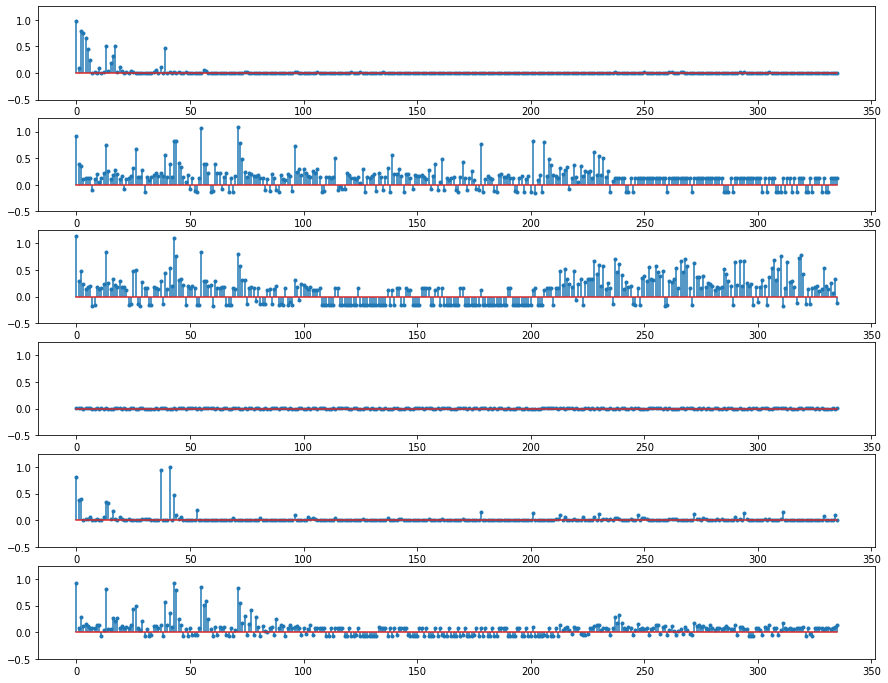

In [ ]:
# umap
plt.figure(figsize=(15,n_clusters*2))
for i, c in enumerate(c_centers_highd):
  plt.subplot(n_clusters,1,i+1)
  plt.stem(c, use_line_collection=True, markerfmt='.');
  plt.ylim(-0.5, 1.25) # adjust this as needed to display the data

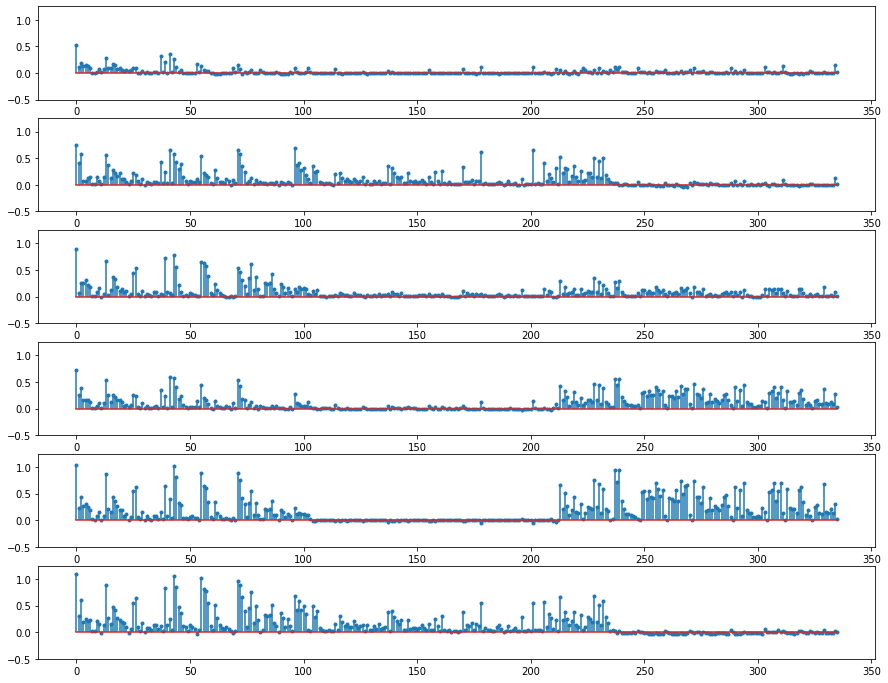

In [ ]:
# pca
plt.figure(figsize=(15,n_clusters*2))
for i, c in enumerate(c_centers_highd_pca):
  plt.subplot(n_clusters,1,i+1)
  plt.stem(c, use_line_collection=True, markerfmt='.');
  plt.ylim(-0.5, 1.25) # adjust this as needed to display the data

A value close to 0 for a particular feature means that most respondents in the cluster did *not* select that option. A value close to 1 for a feature means that most respondents in the cluster *did* select that option.

## Cohort analysis

#### To do 5: use the cluster centers in high dimension feature space to explore cohorts

Use the `c_centers_highd`, the cluster labels `c_responses`, and the original data (either `responses`, `responses_sub`, or `responses_oh`) to explore *each cluster* in greater detail.

For each cluster, see if you can identify:

* What do members of the cluster tend to have in common?
* What do members of the cluster say about the state of machine learning and data science? What tools and techniques do they often use? What are they hoping to use?
* Is the cluster center a good representation of the cluster members?

Also note any important differences between clusters. 

Use this analysis to draw high-level conclusions about the state of machine learning and data science.

Show your analysis (code + output and visualizations) and also summarize your findings in one or more text cells.

At the end, please summarize your findings with a brief description of each "cohort" that you found.

(To help you understand the level of effort expected - this section is worth 4/10 points for this assignment. For full credit, the graders will expect to see an analysis of sufficient detail to justify this point value.)

In [ ]:
c_centers_pca_score = c_centers_highd_pca.tolist() #convert cluster center np array to list
Q_list =[ i[:5] if i[4] == 'A' or i[4] == 'B' else i[:3] for i in plotdata.columns]
#ternary operator & list comphrehension: traverse every question title in plotdata.columns
#if string_index 4 is equaled to 'A' or 'B' then return the string slice up to 5 elements
#else return only 3 elements

Q_list[:25] = [i.replace('_',"") for i in Q_list[:25]] #replace useless symbol for Q7 and Q9 only, parameter obtained through dataframe index

In [ ]:
#stack the above two into the pd dataframe for easier plotting
Q5plot = []
for i in c_centers_highd_pca:
  df = pd.DataFrame(list(zip(Q_list, i)),
                  columns = ['selection', 'c_centers_pca'])
  Q5plot.append(df)
  

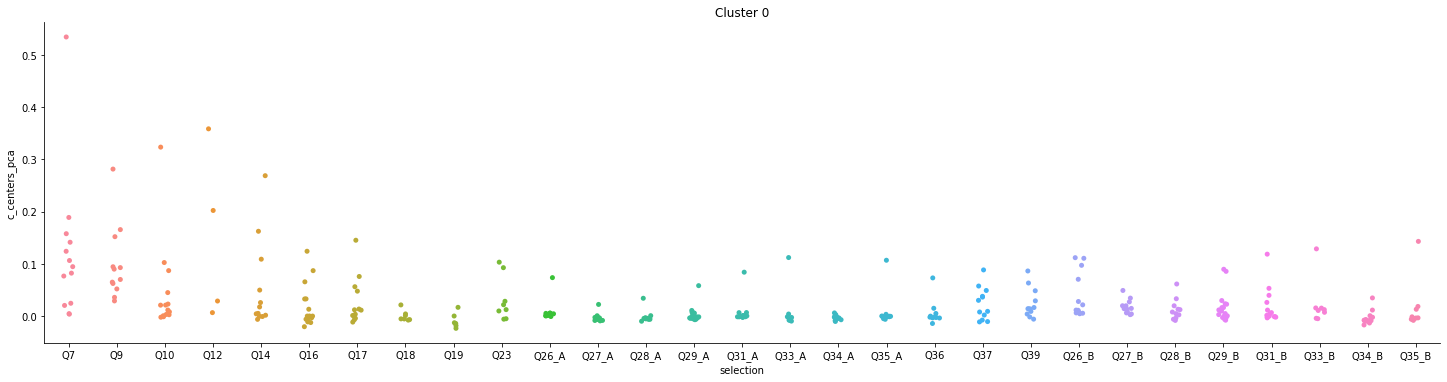

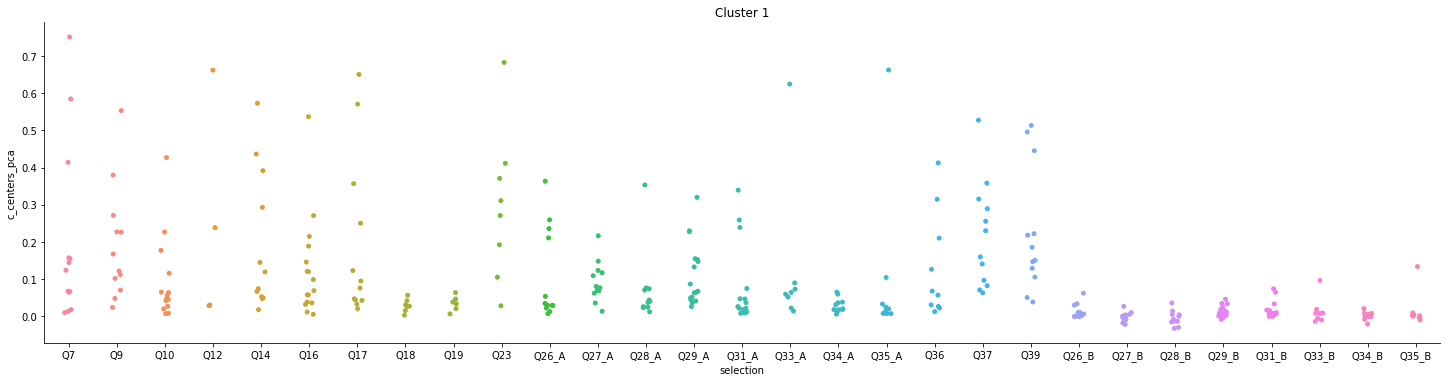

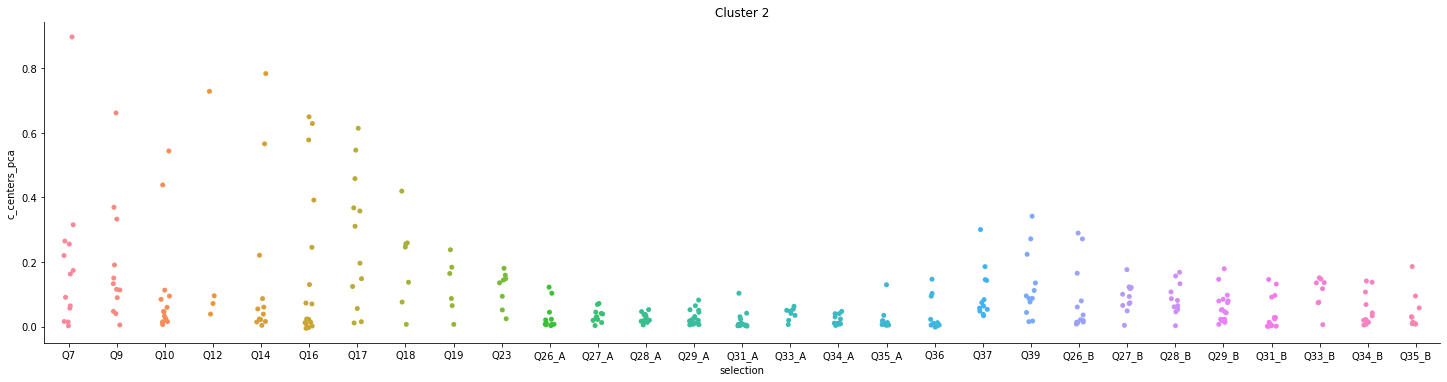

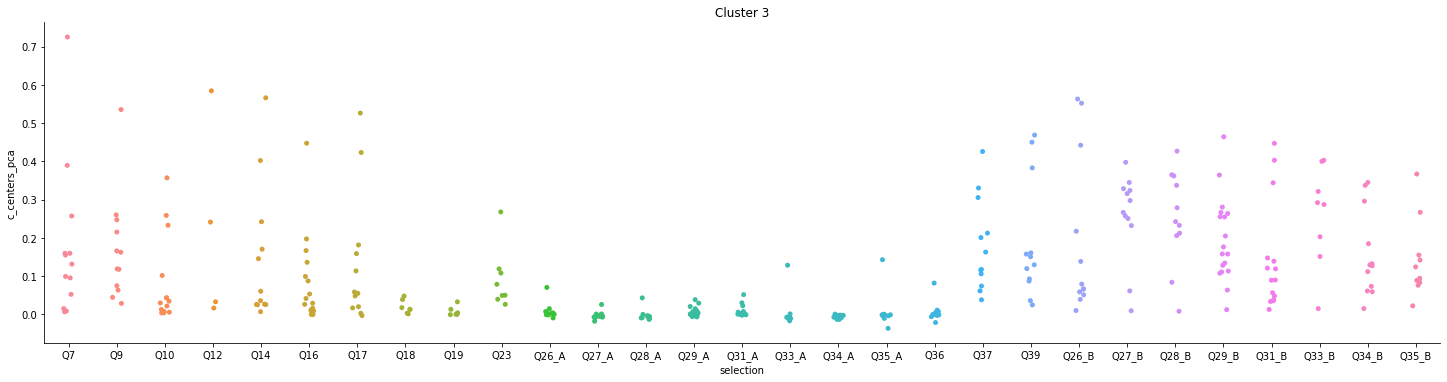

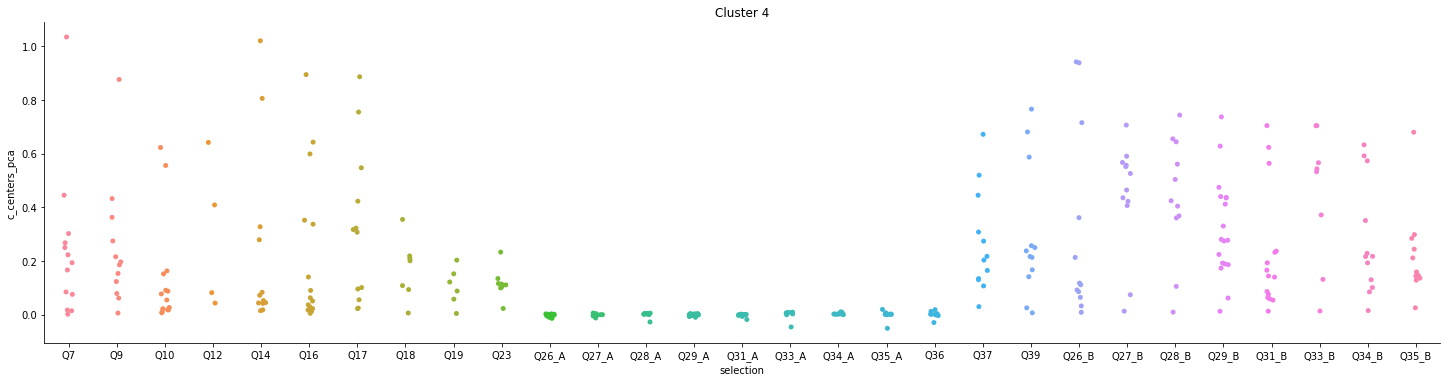

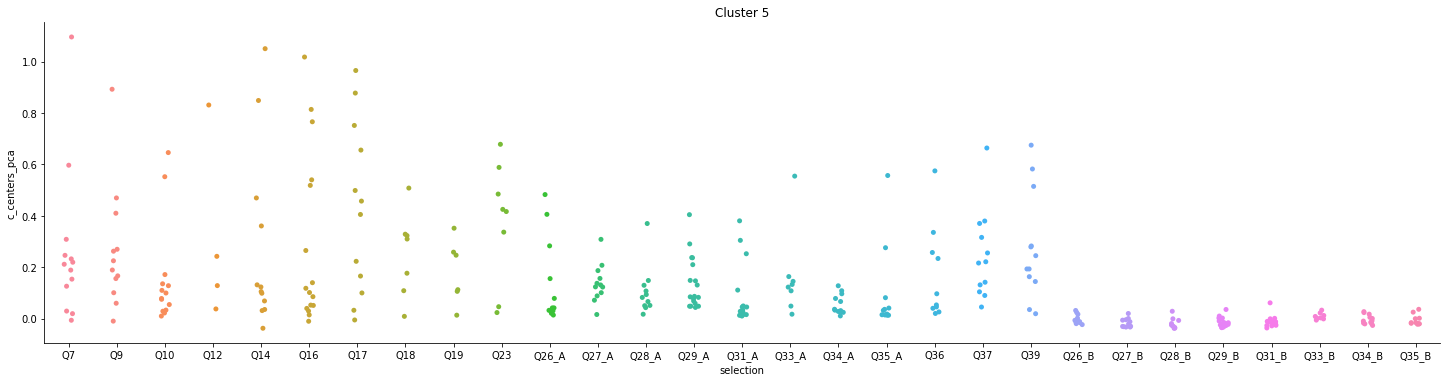

In [ ]:
for i in range(len(Q5plot)):
  sns.catplot(x='selection',y='c_centers_pca',data= Q5plot[i],height=5, aspect=4)
  plt.title("Cluster %s" % i) 
plt.show()

#**What do members of the cluster tend to have in common?**

**I would like to distribute every cluster into 3 sections:**

Section A(Sect-A) is questions range from Q7 - Q23, this is the general section that everybody no matter professionals or students will answer

Section B(Sect-B) is questions range from Q26_A - Q39, this range is specifically for professionals only, require purchase product experience

Section C(Sect-C) is questions range from Q26_B - Q35_B, this range is for students only, asking what they hope to do not what they actually have done

* **Cluster 0:** 

Similarity compare to other clusters: High distribution in Sect-A

Dissimilarity compare to other clusters: Low distribution in both Sect-B and Sect-C

Members common: This cluster have visible non-0 votes across three sections. However, both Sect-B and Sect-C have very similar vertical distribution compared to Sect-A. This might belongs to members who answered both part_A and part_B, instead of just choosing one set to answer. Reasonable to see high distribution in Sect-A because is very general that all users despite career status are able to answer, this same reason applies to the remaining cluster Sect-A.

* **Cluster 1:**

Similarity compare to other clusters: High distribution in both Sect-A and Sect-B

Dissimilarity compare to other clusters: Low distribution in Sect-C

Members common: This is likely belong to “professional” users because of the low distribution in the Sect-C.

* **Cluster 2:**

Similarity compare to other clusters: High distribution in both Sect-A and Sect-C

Dissimilarity compare to other clusters: Medium-low distribution in Sect-B

Members common: This is likely belong to “non-professional” users because of the low distribution in the Sect-B.

* **Cluster 3:**

Similarity compare to other clusters: High distribution in both Sect-A and Sect-C

Dissimilarity compare to other clusters: Low distribution in Sect-B

Members common: This is likely belong to “non-professional” users because of the low distribution in the Sect-B. The difference between this and cluster 2 is the Sect-B in cluster 2 have a little more variety compare to cluster 3. I would classify cluster 3 as the true non-professional group, and the cluster 2 might still have a small mix with professional user but could also be due to users who just happened to answered both sections without awareness/intentionally.

* **Cluster 4:** 

Similarity compare to other clusters: High distribution in Sect-A

Dissimilarity compare to other clusters: Low distribution in Sect-B and medium-low distribution on Sect-C

Members common: This cluster have a little bit higher distribution on the Sect-C, and a small ones in Sect-B. This group could be for users who have limited experience with purchase products but would like to explore more selection options.

* **Cluster 5:** 

Similarity compare to other clusters: High distribution in both Sect-A and Sect-B

Dissimilarity compare to other clusters: Low distribution in Sect-C

(Same as cluster 1 but more compact)

Members common: This is likely to be the true professional group, as indicated, Sect-B have high distribution and as opposed to low distribution in Sect-C.

# **(1)What do members of the cluster say about the state of machine learning and data science? (2)What tools and techniques do they often use? (3)What are they hoping to use?**


In [ ]:
Q5dt = Q5plot.copy() #make a copy so I don't change the dataset for plotting

In [ ]:
top_val = [i for i in plotdata.loc['top']] #get the list of selection names
for i in range(len(Q5dt)):
  Q5dt[i]['top_val'] = top_val #stack the list into dataframe

In [ ]:
#cluster 0
Q5dt[0].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index() #sort based on c_centers_pca values with unique question number and based on dataframe index


,selection,c_centers_pca,top_val
0,Q7,0.534198,Python
13,Q9,0.281414,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
37,Q10,0.323434,None
41,Q12,0.358419,None
43,Q14,0.268757,Matplotlib
55,Q16,0.124188,Scikit-learn
71,Q17,0.145259,Linear or Logistic Regression
88,Q18,0.021498,None
94,Q19,0.016863,None
96,Q23,0.103293,Analyze and understand data to influence product or business decisions


(1) This cluster member do not seem to be very familiar with the ML products/techniques. They use popular language and notebook as the rest of the cluster memebers.

(2)
* 0	Q7	0.533954	Python
* 13	Q9	0.281136	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 43	Q14	0.268406	Matplotlib
* 55	Q16	0.123785	Scikit-learn
* 71	Q17	0.144860	Linear or Logistic Regression
* 96	Q23	0.103038	Analyze and understand data to influence product or business decisions
* 211	Q36	0.073097	I do not share my work publicly
* 230	Q39	0.086182	YouTube (Kaggle YouTube, Cloud AI Adventures, etc)

(3)

* 239	Q26_B	0.111812	Google Cloud Platform (GCP)
* 272	Q29_B	0.089659	MySQL

In [ ]:
#cluster 1
Q5dt[1].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index()
Q5dt[0].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index() #sort based on c_centers_pca values with unique question number and based on dataframe index

,selection,c_centers_pca,top_val
0,Q7,0.534198,Python
13,Q9,0.281414,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
37,Q10,0.323434,None
41,Q12,0.358419,None
43,Q14,0.268757,Matplotlib
55,Q16,0.124188,Scikit-learn
71,Q17,0.145259,Linear or Logistic Regression
88,Q18,0.021498,None
94,Q19,0.016863,None
96,Q23,0.103293,Analyze and understand data to influence product or business decisions


(1)
This cluster member seems to have more familiarity than the cluster 0 members. They believe online platform contain the most useful resources for ML.

(2)
* 0	Q7	0.751128	Python
* 13	Q9	0.552845	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 43	Q14	0.572088	Matplotlib
* 55	Q16	0.536022	Scikit-learn
* 71	Q17	0.650566	Linear or Logistic Regression
* 90	Q19	0.062046	Word embeddings/vectors (GLoVe, fastText, word2vec)
* 96	Q23	0.684142	Analyze and understand data to influence product or business decisions
* 104	Q26_A	0.363198	Amazon Web Services (AWS)
* 116	Q27_A	0.216010	Amazon EC2
* 139	Q29_A	0.319703	MySQL
* 206	Q36	0.412471	GitHub
* 213	Q37	0.527807	Coursera
* 228	Q39	0.513592	Kaggle (notebooks, forums, etc)

(3) 
* 272	Q29_B	0.045219	MySQL
* 294	Q31_B	0.073581	Tableau

In [ ]:
#cluster 2
Q5dt[2].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index()

,selection,c_centers_pca,top_val
0,Q7,0.897005,Python
13,Q9,0.661699,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
26,Q10,0.543912,Colab Notebooks
39,Q12,0.728566,GPUs
43,Q14,0.783624,Matplotlib
55,Q16,0.649709,Scikit-learn
77,Q17,0.614322,Convolutional Neural Networks
86,Q18,0.419664,"Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)"
90,Q19,0.237902,"Word embeddings/vectors (GLoVe, fastText, word2vec)"
98,Q23,0.180582,Build prototypes to explore applying machine learning to new areas


(1)This cluster have more non-professional members. They are interested to tryout differen online platform as well as other resources that are not so popular among purchased users(in other cluster)

(2)
* 0	Q7	0.725585	Python
* 13	Q9	0.535870	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 43	Q14	0.566646	Matplotlib
* 55	Q16	0.447857	Scikit-learn
* 71	Q17	0.526553	Linear or Logistic Regression
* 96	Q23	0.267594	Analyze and understand data to influence product or business decisions
* 191	Q34_A	0.000668	Other
* 211	Q36	0.081696	I do not share my work publicly
* 213	Q37	0.426033	Coursera
* 228	Q39	0.469135	Kaggle (notebooks, forums, etc)

(3)

* 237	Q26_B	0.563948	Amazon Web Services (AWS)
* 255	Q27_B	0.398304	Google Cloud Compute Engine
* 266	Q28_B	0.427499	Google Cloud AI Platform / Google Cloud ML Engine
* 272	Q29_B	0.465026	MySQL
* 294	Q31_B	0.447813	Tableau
* 307	Q33_B	0.403623	Automated model selection (e.g. auto-sklearn, xcessiv)
* 319	Q34_B	0.345655	Auto-Sklearn
* 329	Q35_B	0.367689	TensorBoard

In [ ]:
#cluster 3
Q5dt[3].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index()

,selection,c_centers_pca,top_val
0,Q7,0.725352,Python
13,Q9,0.535599,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
37,Q10,0.357028,None
41,Q12,0.584579,None
43,Q14,0.566267,Matplotlib
55,Q16,0.447542,Scikit-learn
71,Q17,0.526319,Linear or Logistic Regression
88,Q18,0.048028,None
94,Q19,0.032901,None
96,Q23,0.267948,Analyze and understand data to influence product or business decisions


(1) This have a large combination of both professionals and non-professionals. Based on the voting score, professionals do not have agreements on what's the best purchased products, however, non-professionals have strong agreements on what are some popular products that they would like to try.

(2)
* 0	Q7	1.036177	Python
* 13	Q9	0.877455	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 26	Q10	0.624374	Colab Notebooks
* 39	Q12	0.644088	GPUs
* 43	Q14	1.022065	Matplotlib
* 55	Q16	0.895899	Scikit-learn
* 71	Q17	0.887152	Linear or Logistic Regression
* 86	Q18	0.356355	Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)
* 90	Q19	0.203814	Word embeddings/vectors (GLoVe, fastText, word2vec)
* 96	Q23	0.232666	Analyze and understand data to influence product or business decisions
* 106	Q26_A	0.003138	Google Cloud Platform (GCP)
* 122	Q27_A	0.005831	Google Cloud Compute Engine
* 133	Q28_A	0.005349	Google Cloud AI Platform / Google Cloud ML Engine
* 141	Q29_A	0.003733	SQLite
* 159	Q31_A	0.001561	Google Data Studio
* 172	Q33_A	0.009079	Automated data augmentation (e.g. imgaug, albumentations)
* 186	Q34_A	0.010102	Auto-Sklearn
* 196	Q35_A	0.019939	TensorBoard
* 209	Q36	0.018759	Colab
* 213	Q37	0.671780	Coursera
* 228	Q39	0.765714	Kaggle (notebooks, forums, etc)

(3)

* 239	Q26_B	0.941015	Google Cloud Platform (GCP)
* 255	Q27_B	0.705160	Google Cloud Compute Engine
* 266	Q28_B	0.742254	Google Cloud AI Platform / Google Cloud ML Engine
* 272	Q29_B	0.735531	MySQL
* 294	Q31_B	0.702951	Tableau
* 310	Q33_B	0.702937	Automation of full ML pipelines (e.g. Google Cloud AutoML, H20 Driverless AI)
* 319	Q34_B	0.631684	Auto-Sklearn
* 329	Q35_B	0.678710	TensorBoard

In [ ]:
#cluster 4
Q5dt[4].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index()

,selection,c_centers_pca,top_val
0,Q7,1.035469,Python
13,Q9,0.876964,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
26,Q10,0.623162,Colab Notebooks
39,Q12,0.642049,GPUs
43,Q14,1.021213,Matplotlib
55,Q16,0.895024,Scikit-learn
71,Q17,0.887019,Linear or Logistic Regression
86,Q18,0.354757,"Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)"
90,Q19,0.202820,"Word embeddings/vectors (GLoVe, fastText, word2vec)"
96,Q23,0.232736,Analyze and understand data to influence product or business decisions


(1)
Also a combination of both the professional and non-professional users. In this cluster, both group do not have strong agreements on the best purchased/promising products that they like to use, except the general agreement on popular ML language and notebook, etc.

(2)

* 0	Q7	0.895408	Python
* 13	Q9	0.659938	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 26	Q10	0.541759	Colab Notebooks
* 39	Q12	0.726388	GPUs
* 43	Q14	0.781226	Matplotlib
* 55	Q16	0.647455	Scikit-learn
* 77	Q17	0.611983	Convolutional Neural Networks
* 86	Q18	0.417961	Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)
* 90	Q19	0.236951	Word embeddings/vectors (GLoVe, fastText, word2vec)
98	Q23	0.180758	Build prototypes to explore applying machine learning to new areas
* 106	Q26_A	0.122461	Google Cloud Platform (GCP)
* 122	Q27_A	0.071735	Google Cloud Compute Engine
* 133	Q28_A	0.052605	Google Cloud AI Platform / Google Cloud ML Engine
* 139	Q29_A	0.082663	MySQL
* 170	Q31_A	0.104124	None
* 172	Q33_A	0.062747	Automated data augmentation (e.g. imgaug, albumentations)
* 186	Q34_A	0.047030	Auto-Sklearn
* 196	Q35_A	0.129445	TensorBoard
* 206	Q36	0.147294	GitHub
* 213	Q37	0.299409	Coursera
* 228	Q39	0.340466	Kaggle (notebooks, forums, etc)



(3)

* 239	Q26_B	0.286858	Google Cloud Platform (GCP)
* 255	Q27_B	0.174234	Google Cloud Compute Engine
* 266	Q28_B	0.165962	Google Cloud AI Platform / Google Cloud ML Engine
* 272	Q29_B	0.177251	MySQL
* 303	Q31_B	0.145501	None
* 307	Q33_B	0.149056	Automated model selection (e.g. auto-sklearn, xcessiv)
* 318	Q34_B	0.139430	Auto-Keras
* 329	Q35_B	0.183795	TensorBoard

In [ ]:
#cluster 5
Q5dt[5].sort_values('c_centers_pca').drop_duplicates('selection', keep='last').sort_index()

,selection,c_centers_pca,top_val
0,Q7,1.096185,Python
13,Q9,0.892699,"Jupyter (JupyterLab, Jupyter Notebooks, etc)"
26,Q10,0.646057,Colab Notebooks
39,Q12,0.831286,GPUs
43,Q14,1.050598,Matplotlib
55,Q16,1.018125,Scikit-learn
71,Q17,0.965633,Linear or Logistic Regression
86,Q18,0.507942,"Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)"
90,Q19,0.351659,"Word embeddings/vectors (GLoVe, fastText, word2vec)"
96,Q23,0.678364,Analyze and understand data to influence product or business decisions


(1)
This is a cluster have a high distribution for professionals. In here, professionals have better agreements on the popular purchased products compare to the previous cluster.

(2)

* 0	Q7	1.095624	Python
* 13	Q9	0.892143	Jupyter (JupyterLab, Jupyter Notebooks, etc)
* 26	Q10	0.645309	Colab Notebooks
* 39	Q12	0.830344	GPUs
* 43	Q14	1.049817	Matplotlib
* 55	Q16	1.017328	Scikit-learn
* 71	Q17	0.965089	Linear or Logistic Regression
* 86	Q18	0.507201	Image classification and other general purpose networks (VGG, Inception, ResNet, ResNeXt, NASNet, EfficientNet, etc)
* 90	Q19	0.351196	Word embeddings/vectors (GLoVe, fastText, word2vec)
* 96	Q23	0.678327	Analyze and understand data to influence product or business decisions
* 104	Q26_A	0.482416	Amazon Web Services (AWS)
* 116	Q27_A	0.308103	Amazon EC2
* 139	Q29_A	0.404241	MySQL
* 186	Q34_A	0.127431	Auto-Sklearn
* 206	Q36	0.574537	GitHub
* 213	Q37	0.663639	Coursera
* 228	Q39	0.674666	Kaggle (notebooks, forums, etc)

(3)

* 309	Q33_B	0.032592	Automated hyperparameter tuning (e.g. hyperopt, ray.tune, Vizier)
* 318	Q34_B	0.026755	Auto-Keras
* 329	Q35_B	0.035852	TensorBoard

# **Is the cluster center a good representation of the cluster members?**

In [ ]:
from collections import Counter
print(Counter(cluster_member for cluster_member in c_responses))

Counter({1: 4706, 5: 4141, 2: 3277, 4: 3238, 0: 2466, 3: 2208})


Cluster 0 - 22.8%

Cluster 1 - 24.1%

Cluster 2 - 6.3%

Cluster 3 - 26.7%

Cluster 4 - 14.9%

Cluster 5 - 5.3%

Even though the ratio distribution is not evenly, but based on the previous 3D plot and the Q5 - scatterplot, I would say they are good representation of the data. None of the cluster have exact overlapping distribution among the 3 sections I specified in the above.
Each of them contribute a valuable representation of a potential user group, specificity indicated in the Q5 first text block.

# **Short Summary**

Cohort 0/cluster 0:
- Represent Sect-A the general survey questions.
- Do not show in-depth usage or understanding of the ML tools/techniques

Cohort 1/cluster 1:
- Most likely to be a professional group representation
- Show online ML resources preference.

Cohort 2/cluster 2:
- Most likely to be a non-professional group representation
- Have a large variety interest in different ML tools/techniques

Cohort 3/cluster 3:
- Most likely to be a non-professional group representation
- Have a stronger preference in interested ML tools/techniques

Cohort 4/cluster 4:
- A variation of cluster 0, represent mostly in the general survey quesitons. But also have a larger combination of professional and non-professional section answers.
- All Sect-B&C voting score are low, meaning there are mere to none agreements on the popularity of ML tools/techniques

Cohort 5/cluster 5:
- Another representation of professional group, but have more scattered points.
- Voting score show very strong agreements in certain products.
